In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
def cleanData(sentences):
  # remove special characters
  sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)
  # remove 1 letter words
  sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()
  # lower all characters
  sentences = sentences.lower()
  return sentences

In [ ]:
import os
import sys
import pathlib
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

documentPos = []
documentNeg = []


for path in pathlib.Path("/content/drive/MyDrive/nlp2/pos").iterdir():
    if path.is_file():
        current_file = open(path, "r")
        review = cleanData(str(current_file.read()))
        documentPos.append(review)
        current_file.close()

for path in pathlib.Path("/content/drive/MyDrive/nlp2/neg").iterdir():
    if path.is_file():
        current_file = open(path, "r")
        review = cleanData(str(current_file.read()))
        documentNeg.append(review)
        current_file.close()



document = documentPos + documentNeg


labelpos = [1]*1000
labelneg = [0]*1000
label = labelpos + labelneg

data = {'text': document,'label':label,}
df = pd.DataFrame(data)
#df['label'] = label

# print(df.head())

df

,text,label
0,films adapted from comic books have had plenty...,1
1,every now and then movie comes along from susp...,1
2,you ve got mail works alot better than it dese...,1
3,jaws is rare film that grabs your attention be...,1
4,moviemaking is lot like being the general mana...,1
...,...,...
1995,if anything stigmata should be taken as warnin...,0
1996,john boorman zardoz is goofy cinematic debacle...,0
1997,the kids in the hall are an acquired taste it ...,0
1998,there was time when john carpenter was great h...,0


In [ ]:
from sklearn.model_selection import train_test_split
X = df['text']
Y = df['label']

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import nltk
# nltk.download('punkt')
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec

listWords = []
vocab = []
for review in X:
  listWords.append(review.split())

for eachListwords in listWords:
  vocab.append(set(eachListwords))


In [ ]:
# Create CBOW model
model1 = gensim.models.Word2Vec(listWords, min_count = 3, size = 120, window = 10,sg=1,iter=100)    
# model1 = gensim.models.Word2Vec(listWords, min_count = 3, size = 150, window = 5,sg=1)    
# model1 = gensim.models.Word2Vec(listWords, min_count = 3, size = 100, window = 5,sg=1)    
# model1 = gensim.models.Word2Vec(listWords, min_count = 3, size = 120, window = 7,sg=1)    

In [ ]:
len(model1.wv.vocab)

20175

In [ ]:
# Print results
print(model1.wv.similarity('good', 'great'))

0.53754896


In [ ]:
model1.most_similar("genre")

[('slasher', 0.6126530170440674),
 ('horror', 0.5639394521713257),
 ('films', 0.5629593133926392),
 ('flicks', 0.5159400105476379),
 ('thriller', 0.5157788991928101),
 ('aficionados', 0.49728766083717346),
 ('recent', 0.49569928646087646),
 ('action', 0.4848017394542694),
 ('movies', 0.48157167434692383),
 ('fiction', 0.47945791482925415)]

In [ ]:
def get_mean_vector(word2vec_model, vocab):
    mean_vectors = []
    for words in vocab:
      words = [word for word in words if word in word2vec_model]
      mean_vectors.append(np.mean(word2vec_model[words], axis=0))
    return np.array(mean_vectors)

In [ ]:
mean_vectors = get_mean_vector(model1,vocab)
mean_vectors.shape

(2000, 120)

In [ ]:
X_train_Vector, X_test_Vector, y_train_Vector, y_test_Vector = train_test_split(mean_vectors, Y, test_size=0.33, random_state=42)

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# clf = svm.SVC(kernel='linear',tol=0.01)   #accuracy = 68.03%  other learning values make accuracy worse
clf = svm.LinearSVC(tol=0.01)               #accuracy = 72.42%  tol=0.01 other learning values make accuracy same or worse

clf.fit(X_train_Vector,y_train_Vector)
pred = clf.predict(X_test_Vector)

accuracy_svm = accuracy_score(y_test_Vector, pred)

print('Accuracy: %.2f' % (accuracy_svm*100),'%') 

Accuracy: 84.09 %


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(10, input_dim=len(X_train_Vector[0]), activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print(model.summary())

# fit the keras model on the dataset (training)
his = model.fit(X_train_Vector, y_train_Vector, epochs=2000, batch_size=50, verbose=0)

# evaluate the keras model (testing) 
loss , accuracy = model.evaluate(X_test_Vector, y_test_Vector)
print('Accuracy: %.2f' % (accuracy*100),'%')

21/21 [==============================] - 0s 848us/step - loss: 0.3930 - accuracy: 0.8470
Accuracy: 84.70 %


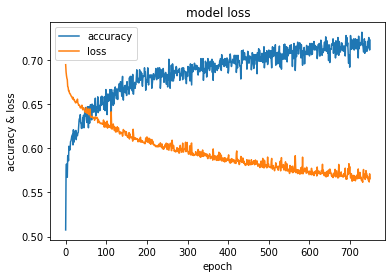

In [ ]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________
